# VAE

Variational Autoencoders are a form of self-supervised learning where the inputs are used as targets.

## Packaging

Tensorflow is a popular open-source library for numeric computation and machine learning.
Within tensorflow is a high level API for building neural networks efficiently called keras.
The layers module in keras API, include some of our favourite architecture layers such as convolutional layers, dense fully connected layers (where each neuron receives an input from all the neurons in the previous layer), LSTM layers.

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

# VAE Encoder Network

A latent space is an abstract representation of the input features. It is a lower dimensional space where the useful features are abstractly presented.

We form our input layer which takes 28 x 28 grayscale images (the 1 channel means our image is grayscale).

## Defining a convolutional layer

We form a 2-D convolutional layer which has 32 filters/kernels (a filter is a small matrix of 3x3 used to extract useful features from data such as our images). We end up with 32 feature maps. The values aka weights inside the matrices initialised randomly meaning, that each filter will look at the data starting from a different angle to learn something meaningful about the data.
After the convolutional layer applies its filters to the input data, creating a feature map, the relu activation function is applied to introduce non-linearity to give our neural network capacities beyond being a linear model. Relu does this by setting negative values to zero.
Stride refers to the number of pixels by which we move our filter across our input data or feature map. The smaller the stride the more detailed the feature map but the more computation you have to do. Hence a trade-off.
We want to compute convolutions on edge regions, for these we would go out of bounds, having zero padding allows us not to go out of bounds and still extract these useful features. Padding "same" means padding will be added such that input data and output from convolutional layer have the same size and width, this is a good way to preserve edge features.
We have then defined in brackets the input data. More information here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

We have defined two convolutional layers. Going from 32 filters to 64 filters, this is a common design patter, where the initial layers learn simple features then proceeding layers learn more detailed representations.
Each of the 64 filters is applied to all previous 32 feature maps to create a new feature map. At the end of the second 2D convolutional layer we have 64 feature maps.


## Defining a dense layer

A dense layer aka a fully connected layers (where each neuron receives an input from all the neurons in the previous layer) can only deal with vectors rather than matrices. So we flatten our useful representations, stacking each column under the other as a vector which we can now pass through the dense layer.

The dense layer has 16 neurons and uses the relu activation function

## Defining the bottleneck

we have defined most the architecture of the encoder but now we need to define the output it encodes, this is known as the bottleneck
the bottleneck which is a compressed low dimensional representation of the input. This is done using latent variables Z.
Latent variables are the things behind what you observed, the underlying pattern behind the picture, the things you learnt.
Well we don't output a fixed value of vectors, we output a gaussian probability distribution of our latent variables given by mean mu, and standard deviation or variance. Gaussian used as it convinient: only has two parameters, its differentiable etc.
Representing the latent space as a probability distribution allows new data to be generated.

If 2-D plane, then two means, two variance represent the two latent variables on each side of the 2-D axis.

All the neurons in the  previous layer connects to the z_mean layer. All the neurons in the  previous layer connects to the z_log_var layer.

## Defining the encoder model

Finally an encoder model is defined.
Input = encoder_inputs
Outputs = z_mean, z_log_var
By defining the output, keras is able to see the computational path that led to this output hence implicitly defining the layers inbetween

## Use of log
as most of our values will fall between 0 and 1, we have nice gradients there
whilst relu between 0 to 1, has instability

In [2]:
# define dimensionality of latent space to be a 2-D plane
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(
    32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [3]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

# Latent-space-sampling layer

Creating a class that inherits properties from layers.Layer which is a base class for creating custom layers
We define a call method/function which is our logic for the forward pass, we take the z_mean and z_log_var 
z_mean is expected to be of size '[batch_size, latent_dim]'

## Reparameterization trick

### Its all about randomness

Randomness exists in Stochastic Gradient Descent (SDG). SDG is the process by which we randomly select data points. This helps us escape local minima and better generalise interms of updating our weights.

However here we have neurons nodes produce outputs which are explicitly random, from a probability distribution. Each time you pass through the node you would get a different output despite same input. Backprogation uses chain rule to provide a determinalistic relationship between nodes. If no determinism, then no backprop. So what we express random sampling in a way that allows back propagation.

1. We generate random values from a normal distribution, the matrix is called epislon. We have defined the same of epsilon.

2. We scale the random values in epsilon to come from the desired distribution  

our randomness is now contained within epsilon which is a constant, whilst the rest of our equation is determinalistic which allows us to do the backpropagation.



In [16]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape= (batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VAE Decoder Network, mapping latent space points to images

-Input layer where we feed z
input layerhas one of its axis shape specified as latent dimension which is 2

- We want to product the same number of coefficients that had at the level of the Flatten layer in the encoder 7*7*64 = 3136, which is what we had if you look at the encoder summary
- Then we want to to revert the flatten layer of the encoder

## Decoder outputs
- The output ends up with shape (28, 28, 1) which is what we originally had
- generates the final image output
- sigmoid typically used for binary or grey scaled image - because it has an output range between 0 and 1
- decoder model takes in latent_inputs and has connected layers to produce decoder_outsputs

In [17]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu") (latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [18]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 1)         289 

# VAE Model with custom train_step()

Define a custom keras model. 
We initialise it with attributes such as the encoder and decoder models aswell as optional key word arguments using a constructor method/function.

We also want VAE to inherit all the optional key word arguments from keras.Model. 
super() returns a temporary object from parent class/base class/superclass keras.Model and allows us to call its functions

We assign encoder and decoder models to instance variables.

Create an instance of Sampler class which is used to sample from latent space

## Metrics

We create three variable instances for tracking loss during training. It computes the weighted mean of given values. Mean of losses across multiple training steps (a training step = a single update based on a batch of training data)
Reconstruction loss - wants standard deviation to be zero so each cluster is distinct
KL-Divergence loss - wants mean zero and s.d 1, as it wants to replicate prior distribution and make sure there are no gaps in our sample space
These are competiting losses

Note:
- Distance between two points = Eucledian distance
- Distance between two vectors = dot product
- Distance between two distributions = KL Divergence

We use a decorator, which is a special type of function that allows us to modify or enhance the behaviour of another function.
property is our decorator we modify the metrics function to output metrics directly without needing to call a method/function.

## Training Step

1. We define a custom training step which takes batch data as the input
2. We open a context manager for recording all operations which we can then use to compute gradients via differentiation
   'with' is used to create a context manager, context manager is a block of code that manages resources such as managing files and databases
   the context manager here is tf.GradientTape() which records the operations performed inside it so that gradients with respect to the tensors inside
   it can be computed later.
3. We pass the input data through the encoder to obtain the mean and log variance of the latent space
4. Then we sample latent variables coordinates (e.g. z1, z2) from the distribution provided with z1 z2 mean and log variance
5. Generate reconstruction of the input data by passing the sampled latent variables through the decoder
6. Calculate reconstruction loss by comparing original data with reconstructed data using binary cross-entropy (0 or 1, checks pixel by pixel)
7. Calculate the KL divergence loss, which measures the difference between the latent variable distribution and a standard normal distribution
8. Calcualte total loss
9. Compute gradients of the total loss (overall loss of our batch data) with respect to each trainable weight. These gradients indicate how much each trainable weight should be adjusted to reduce total loss.
10. Apply gradients to update weights using the specified optimizer. zip pairs each gradient with weight tensor. Update weights in the direction that minimises the loss
11. Update tracking metrics with computed losses
12. Return dictionary of losses over training steps


In [21]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "total_loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }

# Training the VAE

1. Numpy library for numerical and array operations
2. Load mnist data using keras, hand written digits. store in train and testing data
3. _ is a placeholder for labels but no labels being stored e.g. y_train, y_test
4. concatonate x_train and x_test, combining, since we train all MNIST digits and this is self-supervised learning
5. Data needs, extra dimension for channel along the last axis - in our case this extra dimension is the channel since it is greyscaled, we normalize each pixel to be between 0 and 1 as before 0 is black and 255 is white. Also convert to floating point calculations as neural network weights are sensitive and need to be precise.
6. Instance of vae class
7. Use compile method to configure how model should be trained, we have specified the optimizer, eager execution allows us to get immediate feedback for intermediate values. We don't need to specify the loss like here https://keras.io/api/metrics/ since we have already specified it in the VAE class.
8. Train mnist_digits for a total of 30 epochs (an epoch is one complete pass through the dataset), batch of 128 images
9. We update weights after each batch, but only print after going through a whole epoch set.

In [22]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 165s 302ms/step - total_loss: 213.3949 - reconstruction_loss: 211.4736 - kl_loss: 1.9213
Epoch 2/30
547/547 [==============================] - 156s 285ms/step - total_loss: 189.5343 - reconstruction_loss: 187.0123 - kl_loss: 2.5221
Epoch 3/30
547/547 [==============================] - 1956s 4s/step - total_loss: 176.1335 - reconstruction_loss: 172.7697 - kl_loss: 3.3636
Epoch 4/30
547/547 [==============================] - 122s 223ms/step - total_loss: 163.4183 - reconstruction_loss: 159.6190 - kl_loss: 3.7992
Epoch 5/30
547/547 [==============================] - 129s 236ms/step - total_loss: 159.8152 - reconstruction_loss: 156.0369 - kl_loss: 3.7781
Epoch 6/30
547/547 [==============================] - 125s 229ms/step - total_loss: 157.6618 - reconstruction_loss: 153.9030 - kl_loss: 3.7588
Epoch 7/30
547/547 [==============================] - 131s 239ms/step - total_loss: 156.2348 - reconstruction_loss: 152.4658 - kl_loss: 3.7691
E

# Sampling a grid of images from the 2D Latent Space

1. Import matplotlib.pyplot library which is used for visualisations
2. We want to display images in a 30x30 grid of digits (900 digits in total)
3. height and width of digits is 28 px
4. Create empty (set to 0) grid of figures, where each element is set initially to 0, it will be used to pixel values for our grid. If you printed it out it should be a black canvas, as px = 0 is black.
5. For grid_x, np.linspace returns n evenly space numbers of interest between -1 and 1, here it is 30
6. For grid_y, np.linspace returns the same but reverses the order using [::-1] so goes e.g. 1, 0.9, 0.8 etc. -1 specifies the step, going in reverse order
7. Essentially we have specified the bounds of each image that will be located in our figure
8. For each grid location we will sample z
9. z_sample is in a latent space, xi represents Z1 or in our case z[0], yi represents Z2 or in our case z[1]
10. x_decoded, takes this z_sample and tries to generate an output that corresponds to an image
11. digit ensures output is reshaped to 28x28
12. populate image grid with generated digits
13. create 15x15 inch figure
14. define the ranges for creating tick labels. Arrange gives evenly spaced values within ranges. pixel_range defines the physical positions (pixel coordinates) on the plot
where tick labels appear, while sample range defines the values that these tick labels
will display which are typically z[0] and z[1] coordinates.
they allow us to label grid points with their corresponding z[0] and z[1] in the visualisation?

 the latent coordinates as well as know where they are located on the grid( pixel coordin

 matplotlib.pyplot.xticks(ticks=None, labels=None, *, minor=False, **kwargs)ticks = pixel position where tick labels will appear
label = actual values tick labels will display which are z[0] z[1] i.e sample range
ates)
15. define axis
16. turn off labels and ticks to make things clean
17. display image on a greyscale theme

1/1 [==============================] - 0s 23ms/step


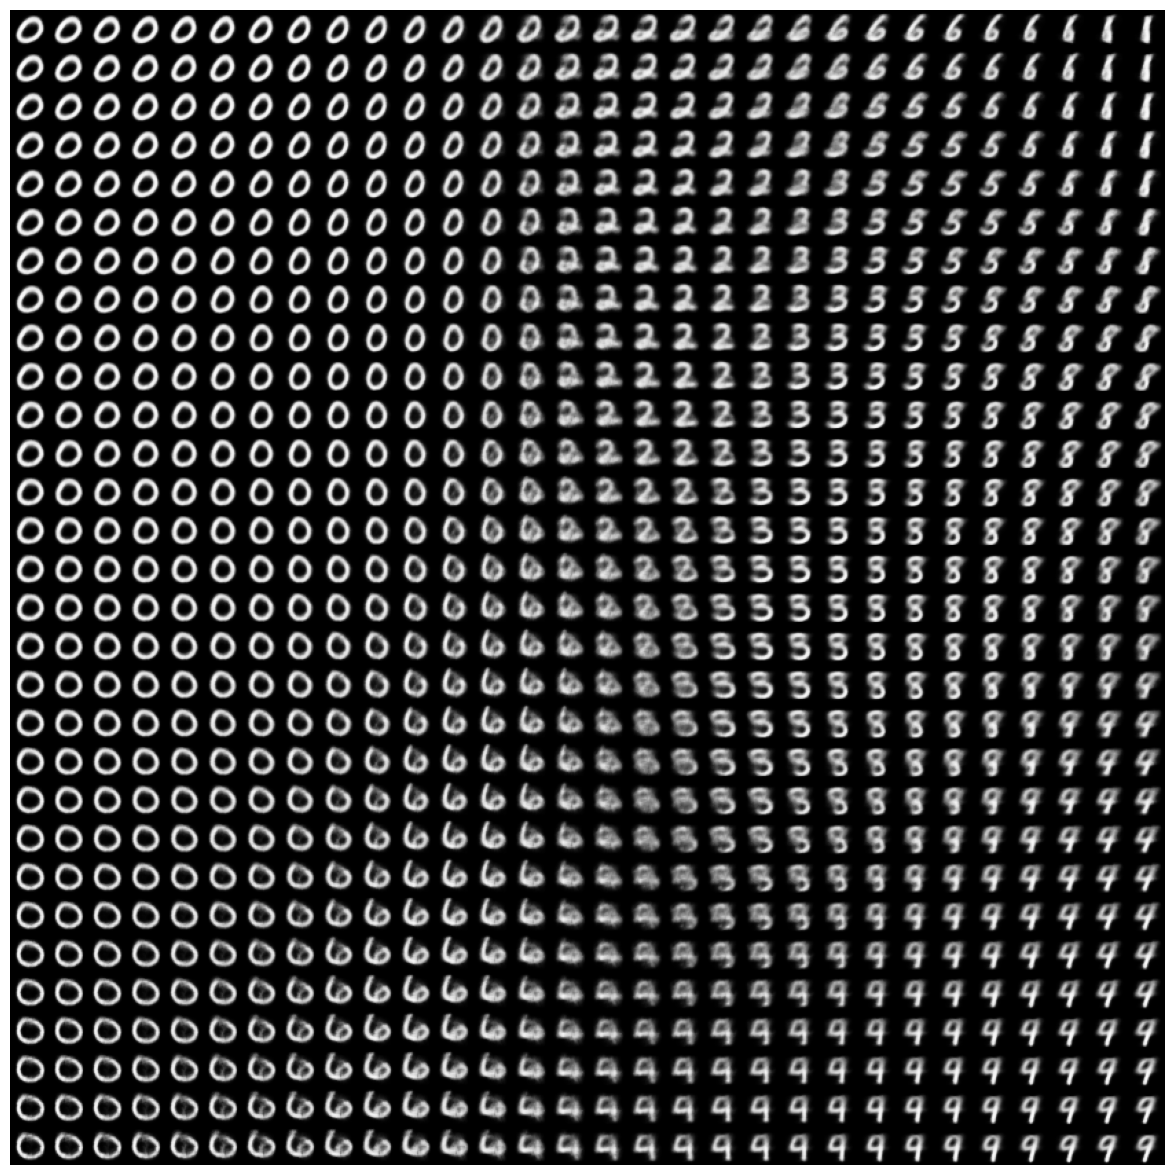

In [23]:
import matplotlib.pyplot as plt

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")